In [1]:
from drn_interactions.interactions.loaders import StateInteractionsLoader
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.pairwise import PairwiseCorr
from drn_interactions.interactions.graph_clustering import df_to_graph
from drn_interactions.config import Config, ExperimentInfo
import numpy as np
from drn_interactions.interactions.graph import GraphAttributes, NodeAttributes
import pandas as pd
import seaborn as sns
from drn_interactions.io import load_derived_generic, load_distances
from drn_interactions.transforms.graph import GraphTransformer
import matplotlib.pyplot as plt
from drn_interactions.plots import PAL_GREY_BLACK
from scipy.stats import chi2_contingency
from tqdm import tqdm
from scipy.stats import wilcoxon
from drn_interactions.stats import mannwhitneyu_plusplus
import pingouin as pg
from scipy.stats import spearmanr

fig_dir = Config.fig_dir
sns.set_theme(style="ticks", context="paper")

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
def load_responders():
    bs_response = load_derived_generic("brain_states_spikerate_responders.csv")[
        ["neuron_id", "Diff", "sig"]
    ].assign(
        response_bs=lambda x: np.where(
            x["sig"] == False,
            "no_response",
            np.where(x["Diff"] < 0, "inhibited", "activated"),
        )
    )[["neuron_id", "response_bs"]]
    phase_lock_response  = (
        load_derived_generic("brain_states_phase_responders.csv")
        .pivot(index="neuron_id", columns="oscillation", values="p")
        [["delta", "theta"]]
        .transform(lambda x: x < 0.5)
        .rename(columns={"delta": "phase_lock_delta", "theta": "phase_lock_theta"})
        .reset_index()
        [["neuron_id", "phase_lock_delta", "phase_lock_theta"]]
    )
    df_responders = pd.merge(bs_response, phase_lock_response, on="neuron_id", how="outer")
    return df_responders
    

In [3]:
sessions = ExperimentInfo.eeg_sessions
neuron_types = load_derived_generic("neuron_types.csv")[
    ["neuron_id", "neuron_type", "session_name"]
]
df_distance = load_distances()
df_ensembles = load_derived_generic("ensembles/bs - ensembles.csv").drop_duplicates()
df_ensembles["in_ensemble"] = np.where(df_ensembles["ensemble_id"] != "-1", True, False)
df_responders = load_responders()

graph_attrs = GraphAttributes(inverse_distance=True)
node_attrs = NodeAttributes()

graph_dfs = []
node_dfs = []
edge_dfs = []

for bin_width in tqdm((0.05, 0.1, 0.5, 1)):
    for state in ("sw", "act"):
        g_transformer = GraphTransformer(
            relabel_nodes=True,
            weight_attr="weight",
            neuron_types=neuron_types,
            df_distance=df_distance,
            df_ensemble=df_ensembles.loc[ (df_ensembles["state"] == state) & (df_ensembles["bin_width"] == bin_width)],
        )
        for session in sessions:
            loader = StateInteractionsLoader(
                session_name=session, bin_width=bin_width, block="pre", state=state
            )
            preprocessor = InteractionsPreprocessor()
            pairwise = PairwiseCorr(rectify=True, shuffle=False)

            spikes = preprocessor(loader())
            df_affinity = (
                pairwise.fit(spikes)
                .get_adjacency_df()
                .dropna(axis=1, thresh=5)
                .dropna(axis=0, thresh=5)
            )
            G = df_to_graph(df_affinity, rename_nodes=True)

            graph_stats = graph_attrs.get_graph_attributes(G)
            node_stats = node_attrs.get_node_attributes(G, node_name="neuron_id")
            edge_stats = g_transformer.graph_to_edge_df(G)

            graph_dfs.append(graph_stats.assign(session=session, state=state, bin_width=bin_width))
            node_dfs.append(node_stats.assign(session=session, state=state, bin_width=bin_width))
            edge_dfs.append(edge_stats.assign(session=session, state=state, bin_width=bin_width))

df_graph = pd.concat(graph_dfs).reset_index(drop=True)
df_edge = pd.concat(edge_dfs).reset_index(drop=True)
df_node = (
    pd.concat(node_dfs)
    .reset_index(drop=True)
    .merge(neuron_types[["neuron_id", "neuron_type"]], how="left")
).drop_duplicates()
df_node = df_node.merge(
    df_ensembles[
        [
            "neuron_id",
            "in_ensemble",
            "state",
            "bin_width",
        ]
    ], on=["neuron_id", "state", "bin_width"], how="left"
).drop_duplicates()
df_node = df_node.merge(df_responders, on="neuron_id", how="left")

  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
 25%|██▌       | 1/4 [00:45<02:17, 45.71s/it]c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packa

In [4]:
dd = Config.derived_data_dir / "graph"

dd.mkdir(exist_ok=True)

df_graph.to_csv(dd / "bs - graph.csv", index=False)
df_node.to_csv(dd / "bs - node.csv", index=False)
df_edge.to_csv(dd / "bs - edge.csv", index=False)

### Graph Props

Does the structure of inactions change between SW and Act?

Metrics:
- Average Clustering
- Normalized Weight
- SWP

n_Inact       15.000000
n_Act         15.000000
Mean_Inact     0.154058
Mean_Act       0.120966
Diff          -0.033092
U             21.000000
p              0.025574
dtype: float64
n_Inact       15.000000
n_Act         15.000000
Mean_Inact     0.227094
Mean_Act       0.193845
Diff          -0.033249
U             36.000000
p              0.187622
dtype: float64


c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\scipy\stats\morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


n_Inact       15.000000
n_Act         15.000000
Mean_Inact     0.428494
Mean_Act       0.346639
Diff          -0.081855
U             25.000000
p              0.272095
dtype: float64


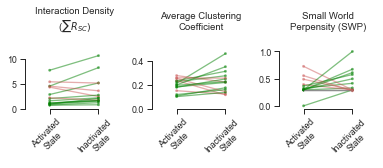

In [12]:

def compare_graph(df, metric):
    piv = df.pivot(index="session", columns="state", values=metric)
    x = piv["Inactivated\nState"]
    y = piv["Activated\nState"]
    res = mannwhitneyu_plusplus(x, y, names=("Inact", "Act"), compare_f=wilcoxon)
    return res

def plot_graph(df, metric, ax=None, **kwargs):
    pg.plot_paired(df, dv=metric, within="state", subject="session", ax=ax, **kwargs)
    return 

dfg = (
    load_derived_generic("graph/bs - graph.csv")
    .loc[lambda x: x.bin_width == 1]
    .copy()
    .assign(state=lambda x: np.where(x.state == "sw", "Inactivated\nState", "Activated\nState"))
    .assign(state=lambda x: pd.Categorical(x.state, categories=["Inactivated\nState", "Activated\nState"]))
)


f = plt.figure(figsize=(6.3, 1.1))

axes = f.subplots(1, 3, sharex=True)

print(compare_graph(dfg, "avg_deg"))

axes[0].set_ylim(0, 12)
plot_graph(dfg, "density",  ax=axes[0], pointplot_kwargs=dict(alpha=0.5), dpi=300,  boxplot=False)
axes[0].set_title("Interaction Density\n($\sum{R_{SC} }$)", pad=20)
# axes[0].set_ylabel(r"$\frac{\sum{R_{SC}}}{N}$")
axes[0].set_ylabel("")
axes[0].set_xlabel("")

print(compare_graph(dfg, "avg_clust"))

axes[1].set_ylim(0, 0.5)
plot_graph(dfg, "avg_clust", ax=axes[1], pointplot_kwargs=dict(alpha=0.5), dpi=300,  boxplot=False)
axes[1].set_title("Average Clustering\nCoefficient", pad=20)
# axes[1].set_ylabel("Clustering Coef")
axes[1].set_ylabel("")
axes[1].set_xlabel("")



print(compare_graph(dfg, "swp"))
plot_graph(dfg, "swp",  ax=axes[2], pointplot_kwargs=dict(alpha=0.5,), dpi=300,  boxplot=False)
axes[2].set_title("Small World\nPerpensity (SWP)", pad=20)
# axes[2].set_ylabel("SWP")
axes[2].set_ylabel("")
axes[2].set_xlabel("")

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")

f.subplots_adjust(wspace=0.3)
f.savefig(fig_dir / "bs - graph stats.png", bbox_inches="tight", dpi=300)

### Node Props

In [83]:

def node_correlate(df, metric):
    piv = (
        df
        [["neuron_id", "state", metric]]
        .drop_duplicates()
        .pivot(index="neuron_id", columns="state", values=metric)
        .dropna()
    )
    x = piv.sw
    y = piv.act
    return mannwhitneyu_plusplus(x, y, names=("sw", "act"), compare_f=spearmanr).round(3)


print("degree\n", node_correlate(dfn, "degree"))
print("\nclust\n", node_correlate(dfn, "clust"))

degree
 n_sw        306.000
n_act       306.000
Mean_sw       0.161
Mean_act      0.131
Diff         -0.030
U             0.504
p             0.000
dtype: float64

clust
 n_sw        306.000
n_act       306.000
Mean_sw       0.216
Mean_act      0.205
Diff         -0.012
U             0.357
p             0.000
dtype: float64


In [85]:
def edge_correlate(df, metric):
    piv = (
        df
        [["comb_id", "state", metric]]
        .drop_duplicates()
        .pivot(index="comb_id", columns="state", values=metric)
        .dropna()
    )
    x = piv.sw
    y = piv.act
    return mannwhitneyu_plusplus(x, y, names=("sw", "act"), compare_f=spearmanr).round(3)


dfe = df_edge.query("bin_width == 1")
print(edge_correlate(dfe, "weight"))

n_sw        1712.000
n_act       1712.000
Mean_sw        0.301
Mean_act       0.280
Diff          -0.021
U              0.465
p              0.000
dtype: float64
